# Burst detection

Liz Strong, 8/7/2019

In [1]:
import sys
sys.path.append('../slvel')

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from IPython.display import set_matplotlib_formats
import burst_det

### make pretty plots

In [13]:
%matplotlib notebook

### Load data

In [42]:
[times,intensity,ang_velocities,vs, Rs, x_offsets, y_offsets] = np.load('example_simulated_signal.npy',allow_pickle=True)

<IPython.core.display.Javascript object>


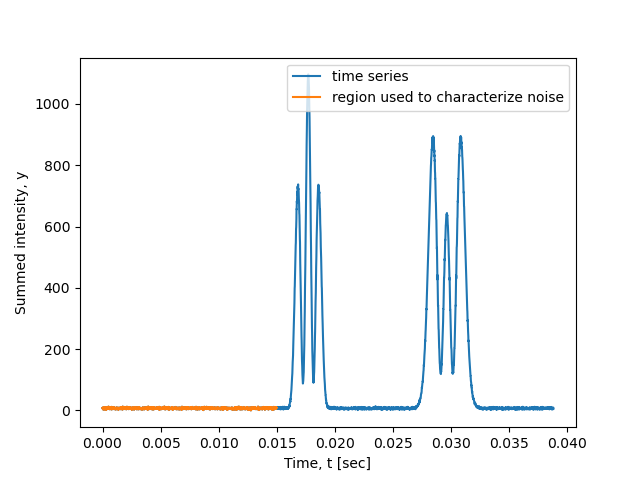

Text(0, 0.5, 'Summed intensity, y')

In [43]:
plt.figure()
plt.plot(times[:15000], intensity[:15000], label='time series')
plt.plot(times[:1500],intensity[:1500], label='region used to characterize noise')
plt.legend()
plt.xlabel('Time, t [sec]')
plt.ylabel('Summed intensity, y')

<IPython.core.display.Javascript object>


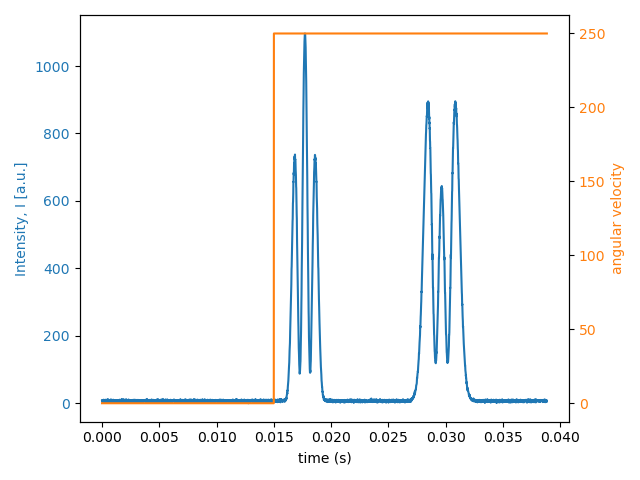

In [44]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Intensity, I [a.u.]', color=color)
ax1.plot(times, intensity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes w/the same x-axis

color = 'tab:orange'
ax2.set_ylabel('angular velocity', color=color)  
ax2.plot(times, vs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to prevent slightly clipping label
plt.show()

## Burst detection

Strategy: 
1. Correlate signal with Rect to determine rough locations of bursts
2. For each rough location, consider a segment of the total signal +/- some distance about its start and end, taking the burst and some of the tail (zero signal + noise) on either side of the burst
3. Verify that all detected bursts are indeed bursts 
4. Extract and save each burst for fitting


### Correlate intensity trace with rect to determine locations of segments containing bursts

In [45]:
## cross correlate signal with rect to determine the rough locations of each burst
area = 400
length = 3200
width = 70
r = burst_det.rect_generator(length,width,area)
xc_r = signal.correlate(intensity,r)[length//2:-length//2]

## determine where cross correlation is above the threshold

# determine threshold. calling the std dev of the total signal 
# approximately the noise, so saying we've got a signal if the area 
# of the analyzing function multiplied by this std dev is less than 
# the value of the correlation.

threshold = area * (np.mean(intensity[:1500]) + 0.5*np.std(intensity[:1500]))

#threshold = area * np.mean(intensity) * .1

# locate where cross correlation is greater than threshold
where_above_threshold = burst_det.find_above_threshold(xc_r, threshold)

## determine the rough position and length of each burst
starts, ends, lengths, areas, rough_location = burst_det.segment_analysis(where_above_threshold,intensity)



<IPython.core.display.Javascript object>


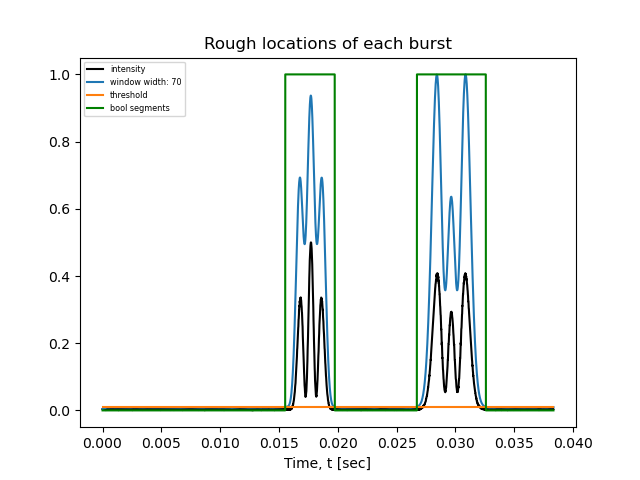

Text(0.5, 0, 'Time, t [sec]')

In [50]:
# plotting
plotstart=0
plotstop=3833
toplot = np.arange(plotstart,plotstop)

plt.figure()
plt.plot(times[toplot],intensity[toplot]/(2*np.max(intensity)),'k',label="intensity")
plt.plot(times[toplot],xc_r[toplot]/np.max(xc_r),label="window width: "+str(width))
plt.plot([0, times[toplot[-1]]],[threshold/np.max(xc_r),threshold/np.max(xc_r)],label="threshold")
plt.plot(times[toplot],rough_location[plotstart:plotstop],'g',label='bool segments')
plt.legend(fontsize='xx-small');
plt.title('Rough locations of each burst');
plt.xlabel('Time, t [sec]')


<IPython.core.display.Javascript object>


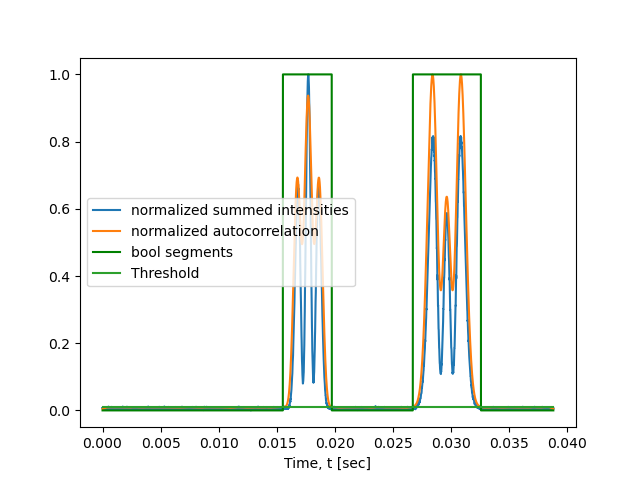

In [53]:
plt.figure()
plt.plot(times, intensity/np.max(intensity), label='normalized summed intensities')
plt.plot(times[:-1], xc_r/np.max(xc_r), label='normalized autocorrelation')
plt.plot(times[:-1], np.array(rough_location,  dtype=int)*1,'g',label='bool segments')
plt.plot([0, times[-1]], [threshold/np.max(xc_r), threshold/np.max(xc_r)], label='Threshold')
plt.xlabel('Time, t [sec]')
plt.legend()

### Inspect segments and eliminate ones which don't correspond to bursts

In [54]:
try:
    bad_start_locns = burst_det.inspect_bursts(xc_r, starts, ends, ang_velocities)
    starts_cleaned, ends_cleaned = burst_det.eliminate_bad_segments(starts, ends, bad_start_locns)
except UnboundLocalError:
    starts_cleaned, ends_cleaned = starts, ends

number of detected segments: 2
number of simulated segments: 2


In [55]:
timeseries_intensity = []
ang_velocities_keep = []
orbit_radii_keep = []
offset_x_keep = []
offset_y_keep = []
clockwise_keep = []

number_segs_per_burst = 1#3

# Iterate through each start and select the signal until the end. 
for st,en in zip(starts_cleaned,ends_cleaned):
    # for each burst, make a couple of segments with different lengths for data augmentation
    for seg_num in range(number_segs_per_burst):
        bu = np.random.randint(80, 120, dtype=np.int8)
        try:
            segment = burst_det.segment_maker(intensity,[st],[en],bu)
            timeseries_intensity.append(segment[0]) # here using segments as our bursts... 
            ang_velocities_keep.append(vs[en]) # save the ends because of how the vs are saved; they extend further into the tails later in time.
            orbit_radii_keep.append(Rs[en])
            offset_x_keep.append(x_offsets[en])
            offset_y_keep.append(y_offsets[en])
            clockwise_keep.append(1)
        except TypeError: #happens when the segment dettected was too short so no segment is returned.
            pass
    
    """# now do the same as aove, but with the segments reversed in time to capture the clockwise/counterclockwise behavior.
    for seg_num in range(number_segs_per_burst):
        bu = np.random.randint(30, 70, dtype=np.int8)
        try:
            segment = segment_maker(intensity[::-1],[len(intensity)-en],[len(intensity)-st],bu) 
            timeseries_intensity.append(segment[0]) # here using segments as our bursts... 
            ang_velocities_keep.append(vs[en]) # save the ends because of how the vs are saved; they extend further into the tails later in time.
            orbit_radii_keep.append(Rs[en])
            offset_x_keep.append(x_offsets[en])
            offset_y_keep.append(y_offsets[en])
            clockwise_keep.append(0)
        except TypeError: #happens when the segment dettected was too short so no segment is returned.
            pass   """ 
    
# make time vectors for each segment
timeseries_time = []
for i in timeseries_intensity:
    t = np.arange(len(i)) * (times[1]-times[0])
    timeseries_time.append(t)

# for each burst, also reverse it in time to simulate clockwise/counterclockwise movement

<IPython.core.display.Javascript object>


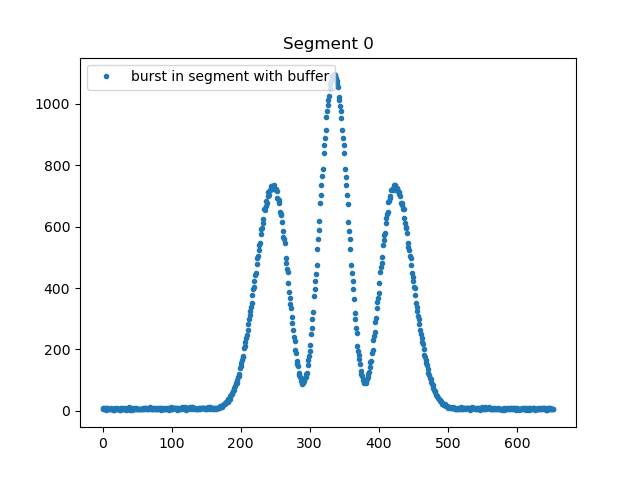

Text(0.5, 1.0, 'Segment 0')

In [56]:
plt.figure()
plt.plot(timeseries_intensity[0], '.', label='burst in segment with buffer')

plt.legend();
plt.title('Segment 0')

### Save bursts for fitting

In [57]:
# save the standard deviation of the noisy baseline to be used in the fitting. 
noise = np.mean(intensity[:1500])
noise_thresh = np.mean(intensity[:1500]) + np.std(intensity[:1500])

# leave the possibility for the noise to be a function of the bursts--this would be necessary 
# if the baseline intensity of the laser or something about the system was changing as a function
# of time.  Recall that we assume that these fluctuations are slow relative to the burst--
# that is, the fluctuations occur on timescales much longer than the time scale of the burst, 
# so analyzing the noise level just before the burst is the same as analyzing it during the burtst
noise_level = noise * np.ones(np.shape(ang_velocities_keep))
noise_threshold = noise_thresh * np.ones(np.shape(ang_velocities_keep))

In [58]:
data_to_save = np.array([timeseries_intensity,timeseries_time,ang_velocities_keep, orbit_radii_keep, offset_x_keep, offset_y_keep, clockwise_keep, noise_level, noise_threshold, number_segs_per_burst])
np.save('example_bursts.npy',data_to_save)